In [227]:
import numpy as np
import qutip as qt
import scqubits as scq
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm

p_bar = qt.ui.TextProgressBar()  # None

In [207]:
#construct the hamiltonian and the corresponding hilbert space

#parameters for the quantum objects 
w1 = 3.0
w2 = 1.0
wc = .8
g1c = .1
g2c = .03
dimc = 2

#building the quantum objects 
qubit1 = scq.GenericQubit(E = w1)
qubit2 = scq.GenericQubit(E = w2)
cavity = scq.Oscillator(E_osc=wc, truncated_dim=2)

In [3]:
#build the hilbert space based on the quantum objects

#this builds the basic hamiltonian without the interactions
hilbertspace=scq.HilbertSpace([qubit1,qubit2,cavity])

#build the interaction terms
hilbertspace.add_interaction(
    g_strength = g1c,
    op1 = qubit1.sm_operator,
    op2 = cavity.creation_operator,
    add_hc=True
)
hilbertspace.add_interaction(
    g_strength = g2c,
    op1 = qubit2.sm_operator,
    op2 = cavity.creation_operator,
    add_hc=True
)



In [4]:
#get the overall hamiltonian
hamiltonian = hilbertspace.hamiltonian() 


In [5]:
#diagonalize the hamiltonian and in the process get the dressed modes for the system
hilbertspace.generate_lookup()
bare_labels = (1,0,0) #the state in the product basis (tensored state)
a = hilbertspace.dressed_index(bare_labels) #will give the dressed index but this doesnt mean much 

In [114]:
# get the transition frequency between two states specified by dressed indices
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )

In [69]:

#these are the dressed operators(what do these truly mean) how can i fix the operators that way they are 2 by 2 as opposed to being the size of the hilbert space?
cav_crea = hilbertspace.op_in_dressed_eigenbasis(cavity.creation_operator)
qubit1_sm = hilbertspace.op_in_dressed_eigenbasis(qubit1.sm_operator)
qubit2_sm = hilbertspace.op_in_dressed_eigenbasis(qubit2.sm_operator)

In [99]:
#building the operators with the necessary dimensionality 
# a = qubit1.sm_operator()
# b = cavity.creation_operator()
# aq = qt.Qobj(a)
# bq = qt.Qobj(b)

# int1 = qt.tensor(aq,qt.qeye(2),bq) #first interaction term between the first qubit and the cavity 
# int2 = qt.tensor(qt.qeye(2),qt.Qobj(qubit2.sm_operator()),bq)

# #converting back into an array as opposed to a quantum object
# int1 = np.array(int1)
# int2 = np.array(int2)
# a

array([[0., 0.],
       [1., 0.]])

In [100]:
# #redressing the operators that way they make sense dimensionally 
# cav_crea = hilbertspace.op_in_dressed_eigenbasis(int1)

In [66]:
qubit1_sm

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00 -2.62814217e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.30887061e-04  0.00000000e+00  0.00000000e+00  2.62814217e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  8.30887061e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.99654238e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.62814217e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.99654238e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99654238e-01  0.00000000e+00
  -8.30887061e-04  0.00000000e+00  0.00000000

In [183]:
# The matrix representations can be truncated further for the simulation
total_truncation = 8

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

In [184]:
# get the representation of the qubit and the cavity operators in the dressed eigenbasis of the composite system
qubit1_sm = hilbertspace.op_in_dressed_eigenbasis(qubit1.sm_operator)
qubit2_sm = hilbertspace.op_in_dressed_eigenbasis(qubit2.sm_operator)
cav_crea  = hilbertspace.op_in_dressed_eigenbasis(cavity.creation_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
qubit1_sm = truncate(qubit1_sm, total_truncation)
qubit2_sm = truncate(qubit2_sm, total_truncation)
cav_crea = truncate(cav_crea, total_truncation)

In [185]:
#demo_qutip_fluxoniumcz.ipynb
product_states = [(0,0,0),(1,0,0),(0,1,0),(1,1,0)]
idxs = [hilbertspace.dressed_index((s1,s2,s3)) for (s1,s2,s3) in product_states]
states = [qt.basis(8, idx) for idx in idxs]

computational_subspace = states[:4]

In [216]:
#initial state
psi0 =qt.basis(8, hilbertspace.dressed_index(product_states[1]))
psi0

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

In [224]:
U = qt.tensor(qt.qip.operations.iswap(N=2), qt.identity(dimc))
U = np.array(U)
U = qt.Qobj(U)
#expected final state 
psif = U*psi0

In [196]:
#getting the transition frequency 
omega = transition_frequency(idxs[0],idxs[1])
omega2 = transition_frequency(idxs[1],idxs[2])

# Gaussian pulse parameters optimized by hand
A = 0.022 # GHz
tg = 100 # ns

#Gaussian pulse envelope
def drive_coeff1(t: float, args: dict) -> float:
    return A * np.exp(-8 * t * (t - tg) / tg**2) * np.cos(omega * t)

def drive_coeff2(t: float, args: dict) -> float:
    return A * np.exp(-8 * t * (t - tg) / tg**2) * np.cos(omega2 * t)

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)#truncating the hamiltonian
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

# time-dependent drive Hamiltonian
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * qubit1_sm, drive_coeff1], 
    [2 * np.pi * qubit2_sm, drive_coeff2]# driving through the resonator
]

In [197]:
qt.basis(8, hilbertspace.dressed_index(product_states[2]))
product_states[1]

(1, 0, 0)

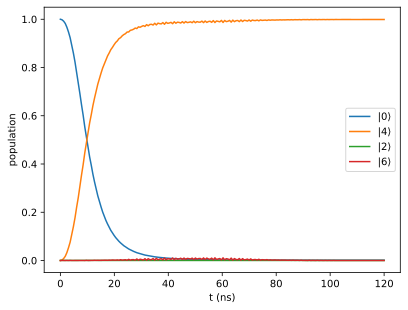

In [198]:
# array of time list
tlist = np.linspace(0, 120, 200)  # total time

# This simulation is just for viewing the effect of the pulse
result = qt.mesolve(
    H_qbt_drive,
    qt.basis(8, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)

for idx, res in zip(idxs, result.expect):
    plt.plot(tlist, res, label=r"$|%u\rangle$" % (idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.show()

In [194]:
hilbertspace.bare_index(0)

(0, 0, 0)

In [195]:
hilbertspace.bare_index(4)

(1, 0, 0)

In [232]:
#sweeping over the parameters in order to find what truly changes the states in the desired way 
#Set up parameter values
t_s=10
amp1_vals = np.linspace(0.0, 5.0, t_s)
amp2_vals = np.linspace(0, 5.0, t_s)

amps = [(amp1, amp2) for amp1 in amp1_vals for amp2 in amp2_vals]

#run the sweep of the parameters to optimize fidelity 
def solver_update(amps):
    amp1, amp2 = amps

    # def coeff1(amp1, t: float) -> float:
    #     return amp1 * np.exp(-t**2)
    
    # def coeff2(amp1, t: float) -> float:
    #     return amp2 * np.exp(-t**2)
    
    one = lambda t: amp1 * np.exp(-t**2)
    two = lambda t: amp2 * np.exp(-t**2)
    
    H_qbt_drive = [
        diag_dressed_hamiltonian_trunc, 
        [qubit1_sm, one],
        [qubit2_sm, two]
    ]

    result = qt.mesolve(
        diag_dressed_hamiltonian_trunc,
        qt.basis(8, hilbertspace.dressed_index(product_states[0])),
        tlist,
        e_ops=[state * state.dag() for state in states]
    )

    final_state = result.states[t_s**t_s - 1]

    # Calculate fidelity with the expected final state
    fidelity = qt.fidelity(psif, final_state)

    return fidelity
    

res = qt.parallel.parallel_map(solver_update, amps, progress_bar=True)


Total run time:   0.64s


IndexError: list index out of range

[(0.0, 0.0),
 (0.0, 0.2631578947368421),
 (0.0, 0.5263157894736842),
 (0.0, 0.7894736842105263),
 (0.0, 1.0526315789473684),
 (0.0, 1.3157894736842104),
 (0.0, 1.5789473684210527),
 (0.0, 1.8421052631578947),
 (0.0, 2.1052631578947367),
 (0.0, 2.3684210526315788),
 (0.0, 2.631578947368421),
 (0.0, 2.894736842105263),
 (0.0, 3.1578947368421053),
 (0.0, 3.4210526315789473),
 (0.0, 3.6842105263157894),
 (0.0, 3.9473684210526314),
 (0.0, 4.2105263157894735),
 (0.0, 4.473684210526316),
 (0.0, 4.7368421052631575),
 (0.0, 5.0),
 (0.2631578947368421, 0.0),
 (0.2631578947368421, 0.2631578947368421),
 (0.2631578947368421, 0.5263157894736842),
 (0.2631578947368421, 0.7894736842105263),
 (0.2631578947368421, 1.0526315789473684),
 (0.2631578947368421, 1.3157894736842104),
 (0.2631578947368421, 1.5789473684210527),
 (0.2631578947368421, 1.8421052631578947),
 (0.2631578947368421, 2.1052631578947367),
 (0.2631578947368421, 2.3684210526315788),
 (0.2631578947368421, 2.631578947368421),
 (0.263157894736